# Classical linear elastostatics

In this demo we discretize the classical linear elatostatics equations using the Galerkin method based on isogeometric function spaces. We follow the notation used in [1] and Bezier extraction [2]. A more mathematical view on the finite element method can be found in [3]. Regarding isogeometric analysis we refer to the first paper [4] and the book [5].


[1] Hughes, Thomas JR. The finite element method: linear static and dynamic finite element analysis. *Courier Corporation*, 2012.


[2] Borden, Michael J., et al. "Isogeometric finite element data structures based on Bézier extraction of NURBS." International Journal for Numerical Methods in Engineering 87.1‐5 (2011): 15-47.

[3] Strang, Gilbert, and George J. Fix. An analysis of the finite element method. Vol. 212. *Englewood Cliffs, NJ: Prentice-Hall*, 1973.

[4] Hughes, T.J., Cottrell, J.A. and Bazilevs, Y., 2005. Isogeometric analysis: CAD, finite elements, NURBS, exact geometry and mesh refinement. *Computer methods in applied mechanics and engineering*, 194(39), pp.4135-4195.

[5] Cottrell, J. Austin, Thomas JR Hughes, and Yuri Bazilevs. Isogeometric analysis: toward integration of CAD and FEA. *John Wiley & Sons*, 2009.

### Initialize path

In [1]:
# addpath library path
push!(LOAD_PATH, pwd());

### Run the following command when running this code for the first time

In [2]:
#Pkg.add("FastGaussQuadrature"); Pkg.add("PyCall"); Pkg.add("PyPlot");

### Load external libraries

In [3]:
using IGA

In [4]:
using PyPlot

# EXAMPLE 1: Patch Test

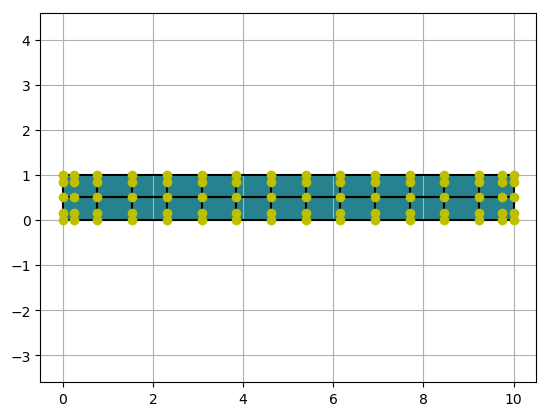

In [5]:
# particulars
p   = [1,1]                                                                  # polybnomial degree
kts = Vector{Float64}[buildvector([0.0;1.0], [p[k]+1;p[k]+1]) for k in 1:2]  # knot vector

# control points and weights
X = 10.0*[0.0  1.0 0.0 1.0];
Y = [0.0 0.0  1.0 1.0];
W = ones(4)

# construct patch
S = NURBS(p,kts,[X[:] Y[:]],W[:])
degreeelevate!(S,2)                  # degree elevate both direction to cubics
globalrefine!(S,1,12)                # global refine direction 1
globalrefine!(S,2,1)                 # global refine direction 1

# compute and store dependent data
S.dec = bezierdecompoperator(S)      # compute Bezier decomposition operator
S.ien = ienarray(S)                  # determine ien array

# plot geometry
plot(S,(10,10));  axis("equal"); xlim([-0.5;10.5]); grid("on");    # plot surface
plot(S.cpts[:,1], S.cpts[:,2],"yo");                               # plot nodal data

### The IEN-array is given by:

In [6]:
S.ien

16×26 Array{Int64,2}:
  1   2   3   4   5   6   7   8   9  …  21  22  23  24  25  26  27  28  29
  2   3   4   5   6   7   8   9  10     22  23  24  25  26  27  28  29  30
  3   4   5   6   7   8   9  10  11     23  24  25  26  27  28  29  30  31
  4   5   6   7   8   9  10  11  12     24  25  26  27  28  29  30  31  32
 17  18  19  20  21  22  23  24  25     37  38  39  40  41  42  43  44  45
 18  19  20  21  22  23  24  25  26  …  38  39  40  41  42  43  44  45  46
 19  20  21  22  23  24  25  26  27     39  40  41  42  43  44  45  46  47
 20  21  22  23  24  25  26  27  28     40  41  42  43  44  45  46  47  48
 33  34  35  36  37  38  39  40  41     53  54  55  56  57  58  59  60  61
 34  35  36  37  38  39  40  41  42     54  55  56  57  58  59  60  61  62
 35  36  37  38  39  40  41  42  43  …  55  56  57  58  59  60  61  62  63
 36  37  38  39  40  41  42  43  44     56  57  58  59  60  61  62  63  64
 49  50  51  52  53  54  55  56  57     69  70  71  72  73  74  75  76  77
 50

### Next we define the problems specific data, such as material properties, boundary displacements and tractions, and the ID-array

In [7]:
# Hookean constitutive law
ν = 0.3
E = 10e5
λ = ν*E / ((1+ν)*(1-2ν))
μ = E   / (2*(1+ν))
D(x::Vector{Float64}) = [λ+2μ    λ  0.0
                         λ    λ+2μ  0.0;
                         0.0   0.0    μ];

# analytical solution
σ(x::Vector{Float64}) = [10.0; 0.0; 0.0]

# set righthandside forcing
f(x::Vector{Float64}) = zeros(2)    

# boundary displacements
g(x::Vector{Float64}) = zeros(2)

# set tractions
function h(x::Vector{Float64})
    T = [0.0; 0.0]
    if abs(x[1]-10.0) < 1e-10
        T = σ(x)[[1,3]]
    end
    return T
end

# set ID array
ndofs = dimsplinespace(S)
ID    = ones(Int64, 2, prod(ndofs))             # initialize ID-array
ID[1, ∂(S,1,1).ien[:]] .= 0                     # restrain x-direction on left boundary (dir==1,k==1) 
ID[2, 1] = 0                                    # restrain y-direction of bottom left corner of NURBS Patch

id = 1
for k in 1:length(ID)
    if ID[k]!=0
        ID[k] = id
        id+=1
    end
end
S.id = ID # set ID array

2×80 Array{Int64,2}:
 0  1  3  5  7   9  11  13  15  17  19  …  141  143  145  147  149  151  153
 0  2  4  6  8  10  12  14  16  18  20     142  144  146  148  150  152  154

### Solve the problem

In [8]:
# assmemble equations
K, F = assembly(S, D, f, g, h);

In [9]:
# compute unknown displacements
U = zeros(Float64,size(ID))
U[S.id.!=0] = K \ F;            

### Plot the deformed configuration. With factor $\alpha$ the displacement field can be magnified.

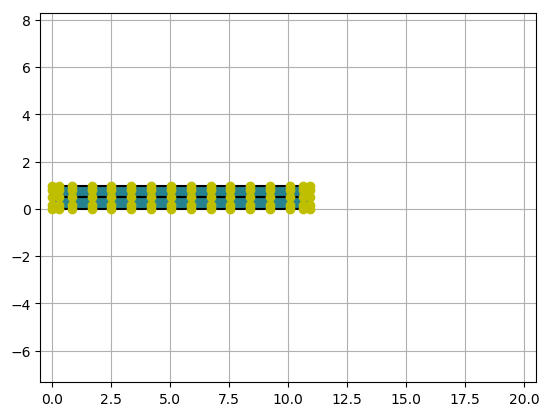

In [10]:
α = 10000                                                    # magnification factor
G = deepcopy(S)                                              # make a copy of the initial geometry
G.cpts += α*U'                                               # update control points
plot(G,(3,3)); axis("equal"); xlim([-0.5;20.5]); grid("on"); # plot deformed configuration
plot(G.cpts[:,1], G.cpts[:,2],"yo");                         # plot nodal data

### Plot the stress componenent in direction $k$.

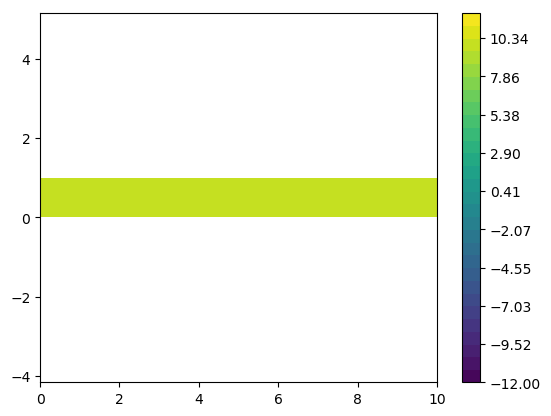

The L² error in stress is: 
 [1.43555e-12, 6.38805e-14, 1.16999e-13]


In [11]:
# plot stress component k
Sol = deepcopy(S); Sol.cpts = U'                                     # make a copy of the initial NURBS geometry
ks  = 1                                                              # Choose component of stress
plot_stress_contours(S, Sol, ks, D, linearspace(-12,12.0,30), (10,10))   # plot the stress field
axis("equal")

# compute L² residual
L2 = L2residual(S, Sol, σ, D)
println("The L² error in stress is: \n $L2")